In [131]:
%load_ext autoreload
%autoreload 2
import numpy as np
import astropy.coordinates
from astropy import units as u
import path
import matplotlib.pyplot as plt
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
dr2period=22/12 # in years
edr3Period=34/12 # in years

308.17368981446947 -12.067243029255737 14.043950846372024 20.39436832461858 9.450155304870979
etas:  [ 0.          0.18027591  0.36055182  0.54082773  0.72110363  0.90137954
  1.08165545  1.26193136  1.44220727  1.62248318  1.80275909  1.983035
  2.1633109   2.34358681  2.52386272  2.70413863  2.88441454  3.06469045
  3.24496636  3.42524227  3.60551817  3.78579408  3.96606999  4.1463459
  4.32662181  4.50689772  4.68717363  4.86744954  5.04772544  5.22800135
  5.40827726  5.58855317  5.76882908  5.94910499  6.1293809   6.30965681
  6.48993271  6.67020862  6.85048453  7.03076044  7.21103635  7.39131226
  7.57158817  7.75186408  7.93213998  8.11241589  8.2926918   8.47296771
  8.65324362  8.83351953  9.01379544  9.19407135  9.37434725  9.55462316
  9.73489907  9.91517498 10.09545089 10.2757268  10.45600271 10.63627862
 10.81655452 10.99683043 11.17710634 11.35738225 11.53765816 11.71793407
 11.89820998 12.07848588 12.25876179 12.4390377  12.61931361 12.79958952
 12.97986543 13.16014134 1

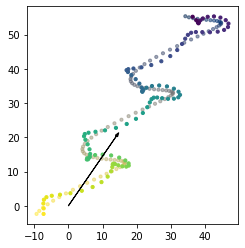

In [165]:
ra=360*np.random.rand()
dec=90*(-1+2*np.random.rand())
pmra=10*np.random.randn()
pmdec=10*np.random.randn()
pllx=10*np.random.rand()
params=path.params()
params.RA=ra
params.Dec=dec
params.pmRA=pmra
params.pmDec=pmdec
params.pllx=pllx
ts=np.sort((34/12)*np.random.rand(64))
ts=np.linspace(0,edr3Period,100)
print(ra,dec,pmra,pmdec,pllx)
ras,decs=path.path(ts,params)
params.M=10
params.q=0.5
params.l=0.1
bras,bdecs=path.path(ts,params)


dRas=(ras-ra)/path.mas2deg
dDecs=(decs-dec)/path.mas2deg
bdRas=(bras-ra)/path.mas2deg
bdDecs=(bdecs-dec)/path.mas2deg
print(dRas)
print(bdRas)

qPl=plt.gca()
timeCmap=mpl.cm.get_cmap('cividis_r')
binaryCmap=mpl.cm.get_cmap('viridis_r')
qPl.scatter(dRas,dDecs,s=10,c=timeCmap(ts/ts[-1]),alpha=0.5)
qPl.scatter(bdRas,bdDecs,s=10,c=binaryCmap(ts/ts[-1]))
qPl.arrow(0,0,pmra,pmdec,head_width=0.8,color='k')
qPl.set_aspect('equal')
plt.show()

In [146]:
print(path.Galt)

39.67806038642986


In [145]:
coord=astropy.coordinates.SkyCoord(ra=10.625*u.degree, dec=0*u.degree, pm_ra_cosdec=2*u.mas/u.yr, pm_dec=2*u.mas/u.yr, frame='icrs')

In [139]:
print(coord.barycentrictrueecliptic)
print(coord.barycentrictrueecliptic.lon.degree)
lat=coord.barycentrictrueecliptic.lat.degree
print(coord.barycentrictrueecliptic.pm_lon_coslat.value/np.cos(np.pi*lat/180))
print(coord.barycentrictrueecliptic.pm_lat.value)
print(np.sqrt((coord.barycentrictrueecliptic.pm_lon_coslat.value/np.cos(np.pi*lat/180))**2+coord.barycentrictrueecliptic.pm_lat.value++2))
print(np.sqrt(8))

<SkyCoord (BarycentricTrueEcliptic: equinox=J2000.000): (lon, lat) in deg
    (9.76187984, -4.20625309)
 (pm_lon_coslat, pm_lat) in mas / yr
    (2.62397437, 1.05582126)>
9.761879842812618
2.631061186369181
1.0558212570902263
3.1588453940496404
2.8284271247461903


In [37]:
coord=astropy.coordinates.SkyCoord(lon=10.625*u.degree, lat=0*u.degree, frame='barycentrictrueecliptic')

In [39]:
print(coord.icrs)

<SkyCoord (ICRS): (ra, dec) in deg
    (9.76931376, 4.20776907)>
